#  Прогнозирование заказов такси на следующий час

## Постановка задачи

Имеются исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси `на следующий час`.<br>
Создать тестовую выборку размером `10%` от исходных данных. Значение метрики `RMSE` на тестовой выборке должно быть `не более 48`.

## Импорт библиотек, загрузка даных

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

import pmdarima as pm

from scipy.stats import jarque_bera, boxcox

from tsfresh.utilities.dataframe_functions import impute, make_forecasting_frame
from tsfresh import extract_features
from tsfresh.feature_selection.relevance import calculate_relevance_table
from tsfresh.feature_extraction import ComprehensiveFCParameters

from catboost import Pool, CatBoostRegressor, cv

import optuna

import warnings

In [2]:
warnings.filterwarnings('ignore')
sns.set_theme(style="darkgrid")
RND_ST = 42

In [3]:
data = pd.read_csv('datasets/taxi.csv',
                   index_col=['datetime'],
                   parse_dates=['datetime'],
                   dayfirst=True)
data.sort_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Ресемплируем данные с диапазоном в 1 час:

In [4]:
data_H = data.resample('1H').sum()
data_H.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

Построим гистограмму распределния значений ряда

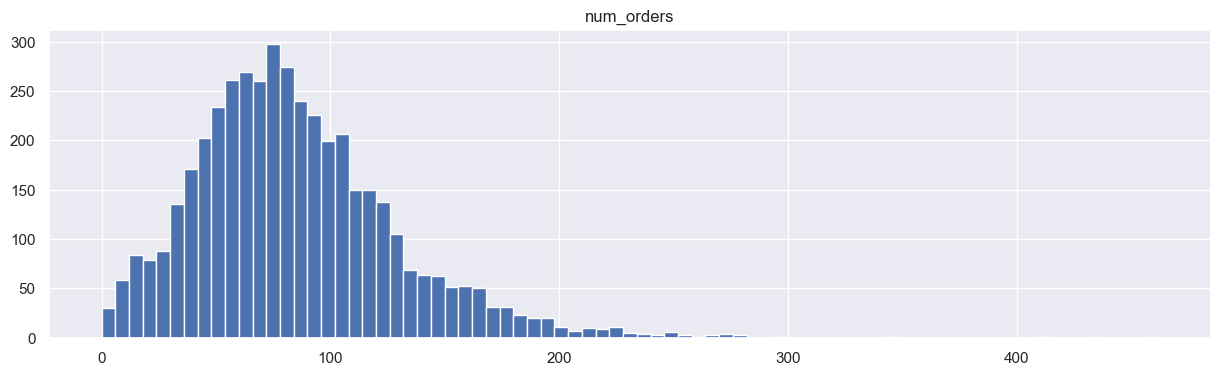

In [6]:
data_H.hist(column='num_orders', bins=77, figsize=(15, 4));

Для проверки гипотезы о нормальном распределении проведем тест Харки-Бера

In [7]:
print(jarque_bera(data_H['num_orders']))

Jarque_beraResult(statistic=3644.4335517264863, pvalue=0.0)


Нулевая гипотеза о том, что данные распределены нормально - отвергается т.к. `p-value --> 0`

Найдем компоненты `Тренд`, `Сезонность` и `Остатки`

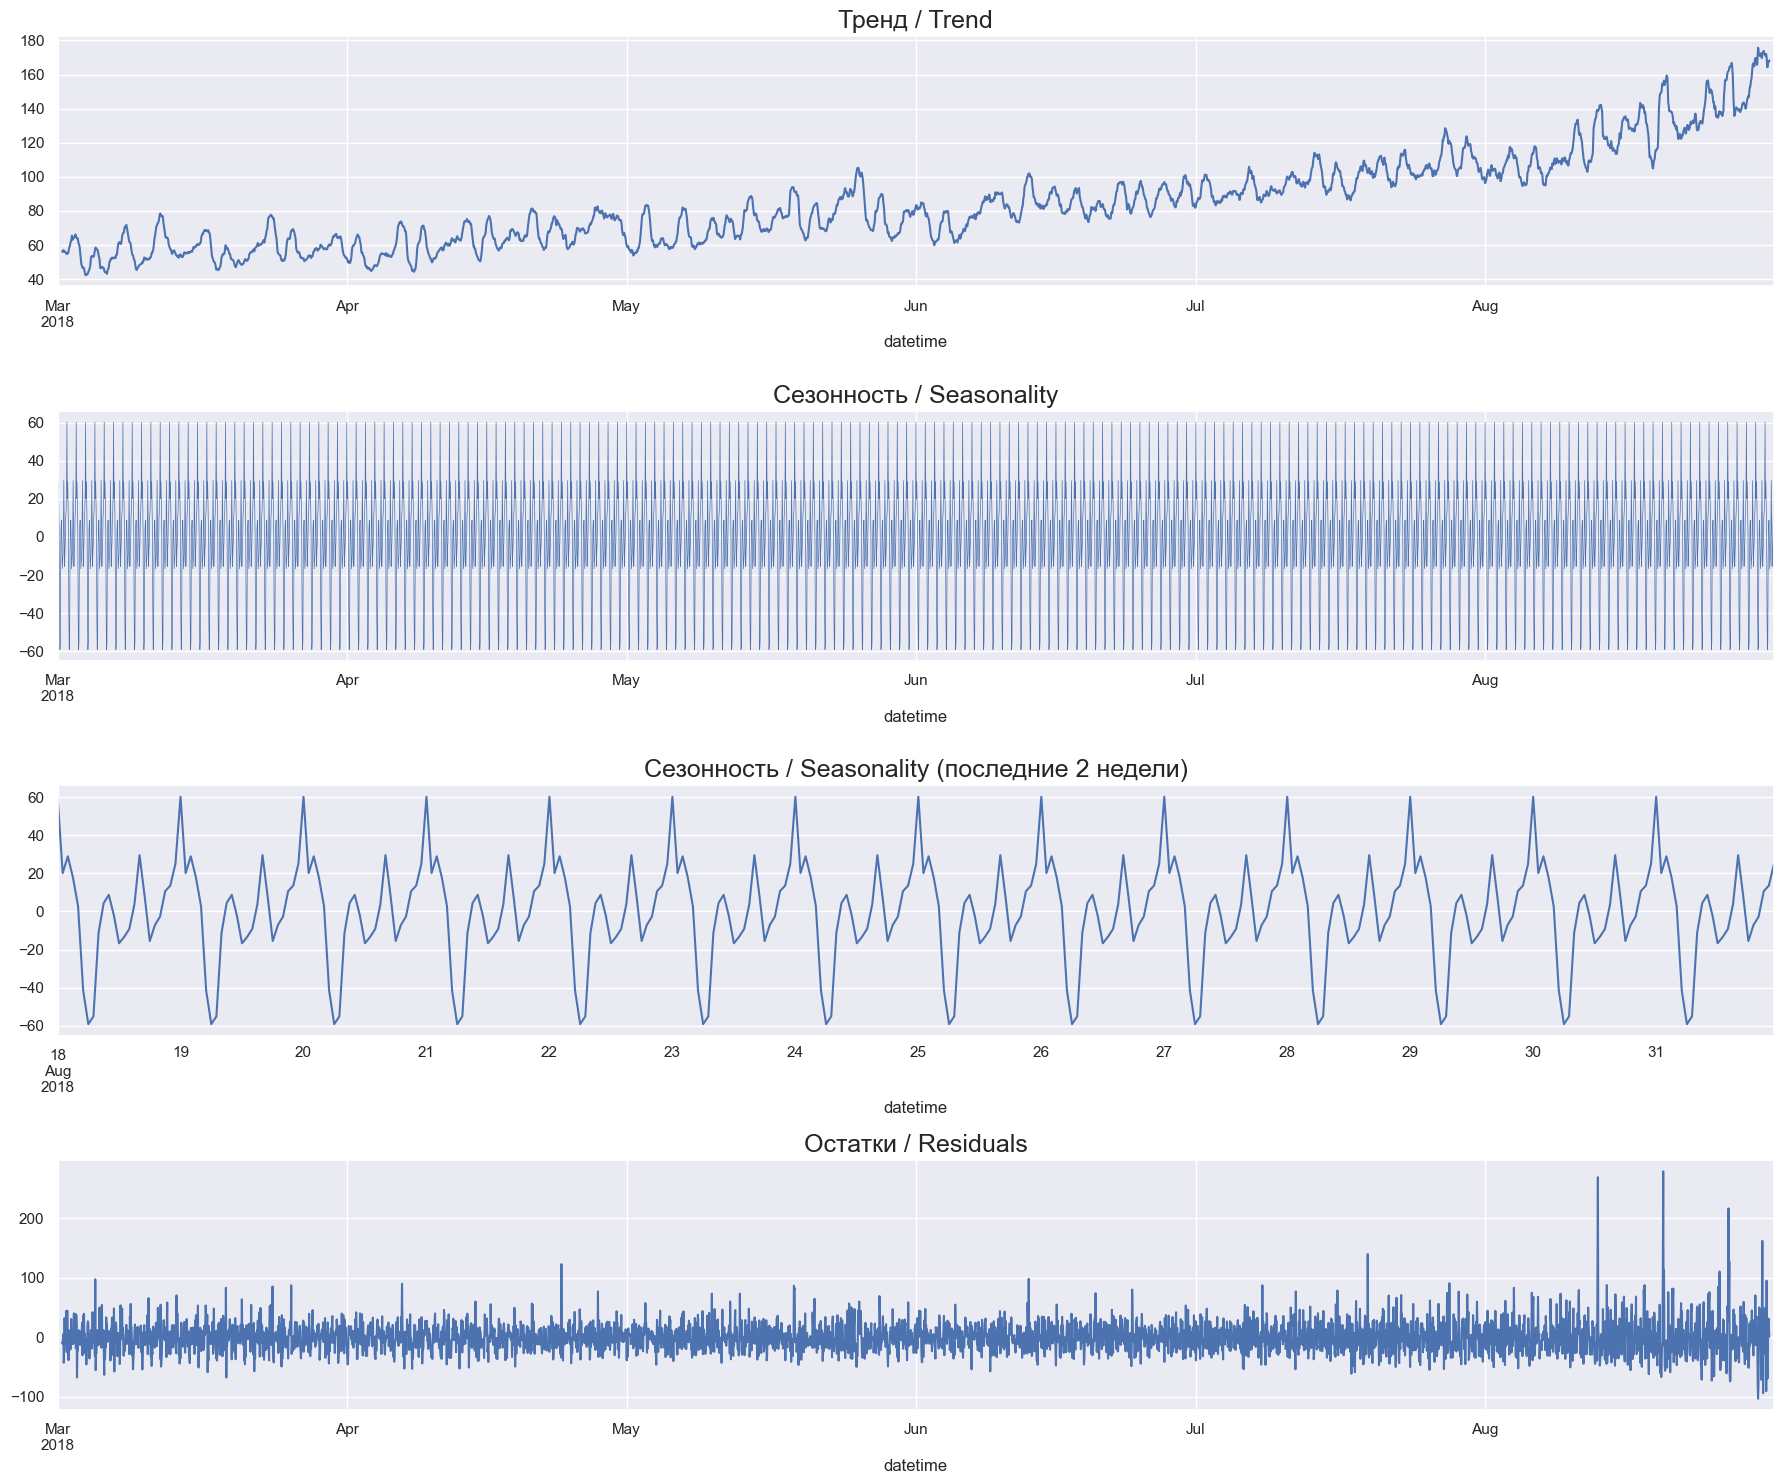

In [8]:
decomposed = seasonal_decompose(data_H['num_orders'])

plt.figure(figsize=(18, 15))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд / Trend', fontsize=18)
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca(), lw=.5) 
plt.title('Сезонность / Seasonality', fontsize=18)
plt.subplot(413)
decomposed.seasonal[-14*24:].plot(ax=plt.gca(), lw=1.5) 
plt.title('Сезонность / Seasonality (последние 2 недели)', fontsize=18)
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Остатки / Residuals', fontsize=18)
plt.tight_layout()

- Тренд существует.
- Сезонность 24 часа.

Проверим ряд на стационарность. Для этого проведем тест Дикки-Фуллера.

- Нулевая гипотеза (H0): Предполагается, что временной ряд имеет единичный корень, т.е. НЕстационарный.
- Альтернативная гипотеза (H1): Предполагается, что временной ряд не имеет единичного корня, т.е. является стационарным.

Будем опираться на значение критерия ADF для 1%

In [9]:
adf_test_H = adfuller(data_H['num_orders'])
print(pd.Series(adf_test_H[2:4], index=['Lags Used', 'Number of Observations Used']))
print('ADF =', adf_test_H[0])
print('p-value = ', adf_test_H[1])
print('Critical values:')
for key, value in adf_test_H[4].items():
    print('\t{}: {}'.format(key, value))
if adf_test_H[0] < adf_test_H[4]['1%']:
    print ('Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print ('Нулевая гипотеза НЕ отвергнута – Временной ряд НЕ стационарен')

Lags Used                        30
Number of Observations Used    4385
dtype: int64
ADF = -3.0689242890279482
p-value =  0.028940051402613506
Critical values:
	1%: -3.431842162413052
	5%: -2.8621993540813637
	10%: -2.567120978470452
Нулевая гипотеза НЕ отвергнута – Временной ряд НЕ стационарен


Проведенный тест подтвердил предположения о нестационарности ряда, хотя если ориентироваться на 5% порог, то ряд можно считать условно стационарным.

Применим к исходному ряду преобразование Бокса-Кокса для уменьшения дисперсии

In [10]:
data_H.min()

num_orders    0
dtype: int64

In [11]:
data_bxcx = data_H[['num_orders']].copy()
data_bxcx['num_orders_bxcx'], lmbda = boxcox(data_bxcx['num_orders'] +1)  # прибавляем 1, т.к. в исходном ряде есть нули
print('Оптимальный параметр преобразования Бокса-Кокса:', lmbda)

Оптимальный параметр преобразования Бокса-Кокса: 0.49959816626526066


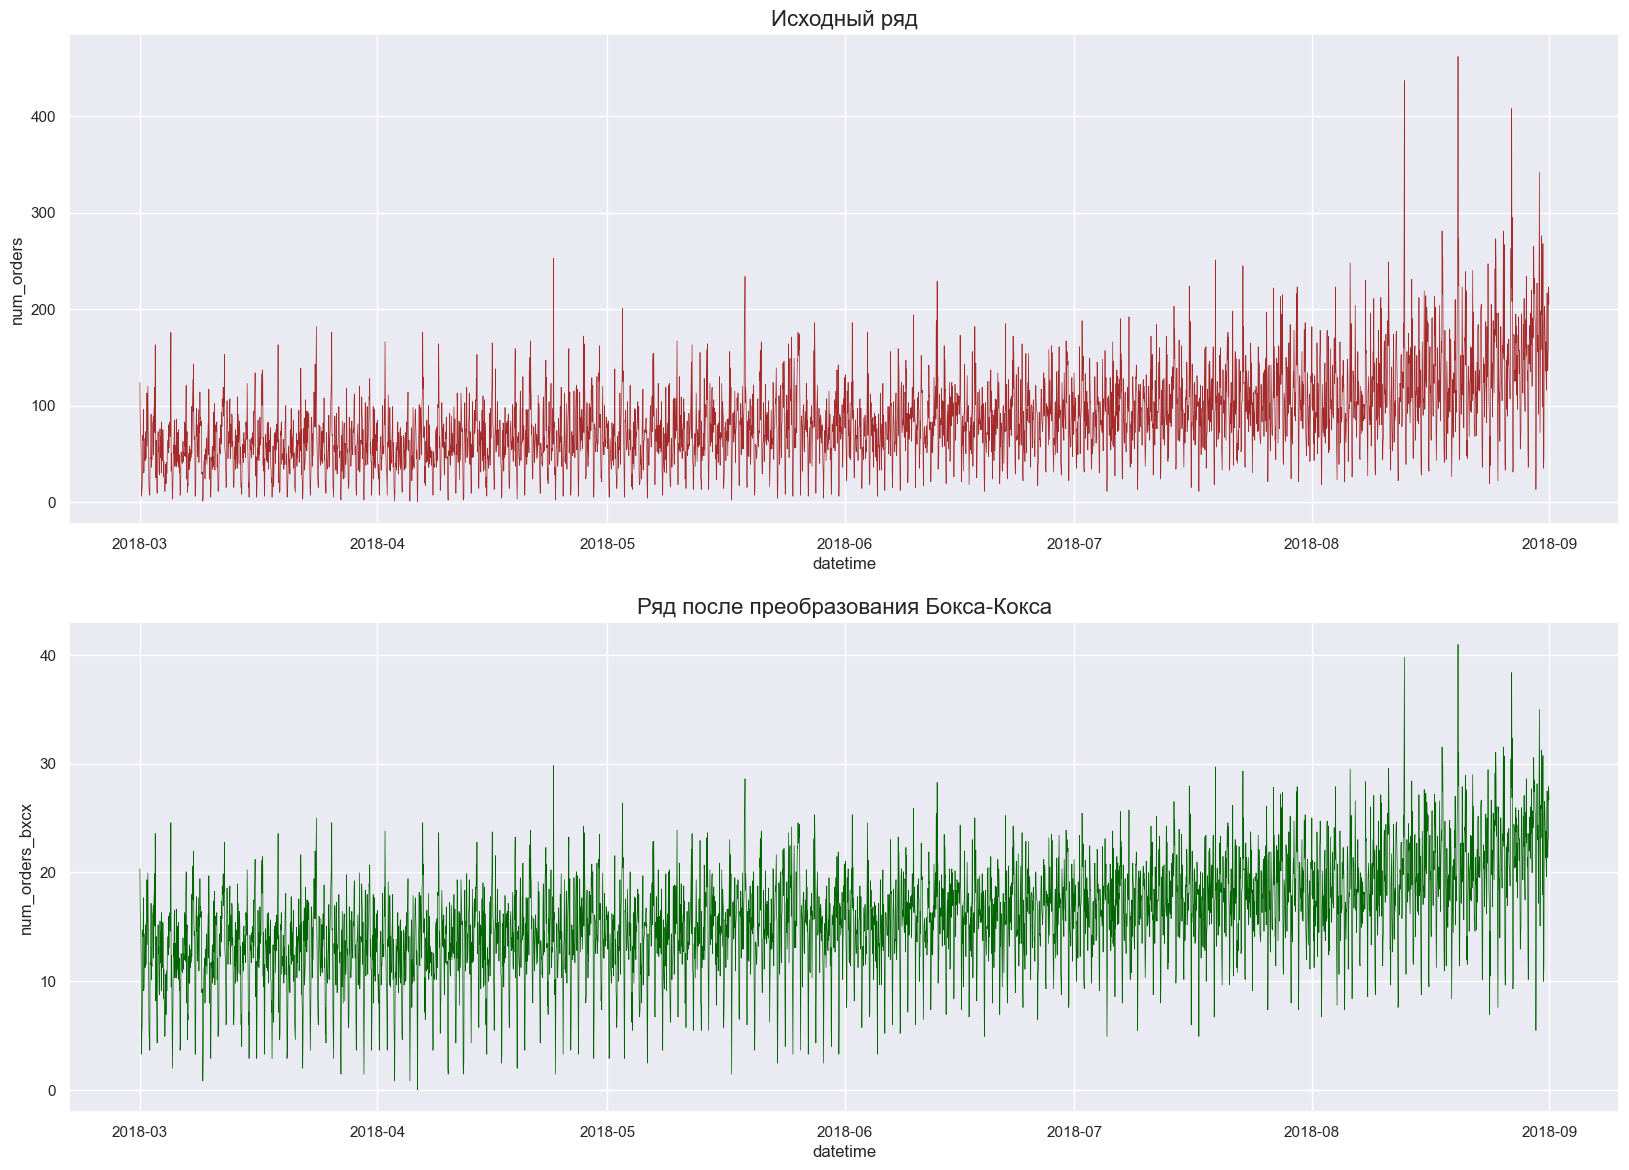

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(20, 14))
sns.lineplot(data=data_bxcx['num_orders'], lw=.5, ax=ax[0], color='brown')
sns.lineplot(data=data_bxcx['num_orders_bxcx'], lw=.5, ax=ax[1], color='darkgreen')
ax[0].set_title('Исходный ряд', fontsize=16)
ax[1].set_title('Ряд после преобразования Бокса-Кокса', fontsize=16)
plt.show()

Дисперсия значительно снизилась!

In [13]:
def invbxcx(y,lmb):
    # обрабтное преобразование Бокса-Кокса
    if lmb == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmb*y+1)/lmb))

Построим автокорреляцию и частичную автокореляцию ряда после преобразования Б.-К.

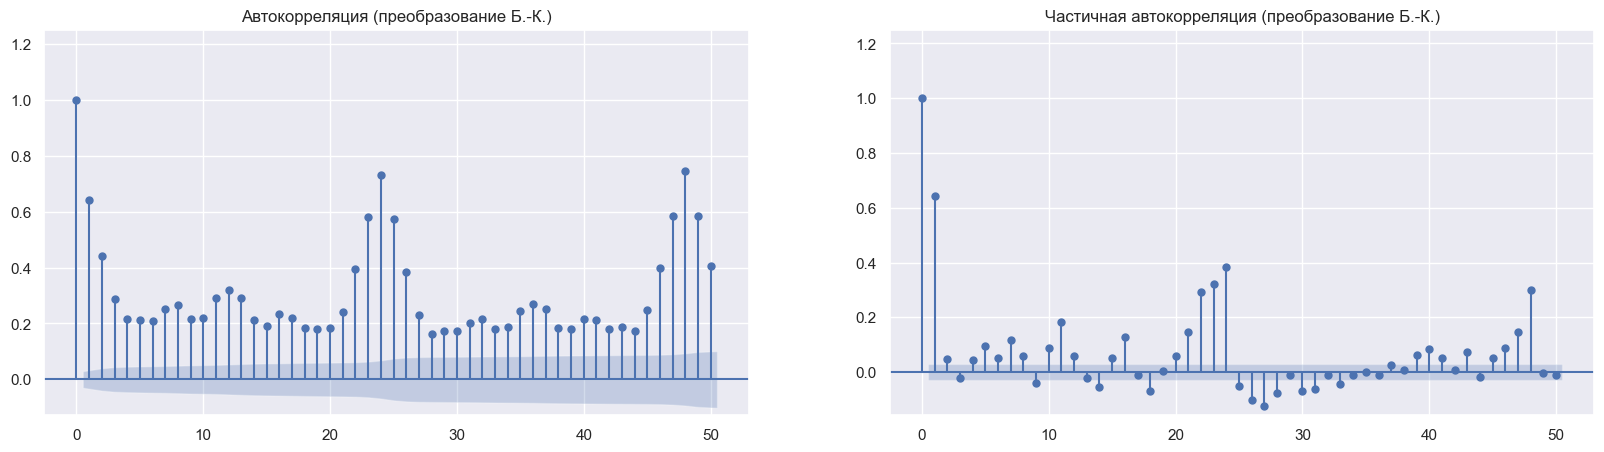

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
plot_acf(data_bxcx['num_orders_bxcx'], lags=50, auto_ylims=True, ax=ax[0], title='Автокорреляция (преобразование Б.-К.)')
plot_pacf(data_bxcx['num_orders_bxcx'], lags=50, method='ywm', auto_ylims=True, ax=ax[1], title='Частичная автокорреляция (преобразование Б.-К.)')
plt.show()

Построим ряд сезонных разностей и сделаем ADF тест

In [15]:
data_bxcx_res1D = data_bxcx['num_orders_bxcx'] - data_bxcx['num_orders_bxcx'].shift(24)
data_bxcx_res1D.dropna(inplace=True)

In [16]:
adf_test_bxcx_res1D = adfuller(data_bxcx_res1D)
print(pd.Series(adf_test_bxcx_res1D[2:4], index=['Lags Used', 'Number of Observations Used']), '\n')
print('ADF =', adf_test_bxcx_res1D[0])
print('p-value = ', adf_test_bxcx_res1D[1])
print('Critical values:')
for key, value in adf_test_bxcx_res1D[4].items():
    print('\t{}: {}'.format(key, value))
if adf_test_bxcx_res1D[0] < adf_test_bxcx_res1D[4]['1%']:
    print ('Нулевая гипотеза отвергнута – Временной ряд стационарен')
else:
    print ('Нулевая гипотеза НЕ отвергнута – Временной ряд НЕ стационарен')

Lags Used                        31
Number of Observations Used    4360
dtype: int64 

ADF = -16.055815573974616
p-value =  5.708973977367933e-29
Critical values:
	1%: -3.4318507234354523
	5%: -2.8622031360567024
	10%: -2.567122991804141
Нулевая гипотеза отвергнута – Временной ряд стационарен


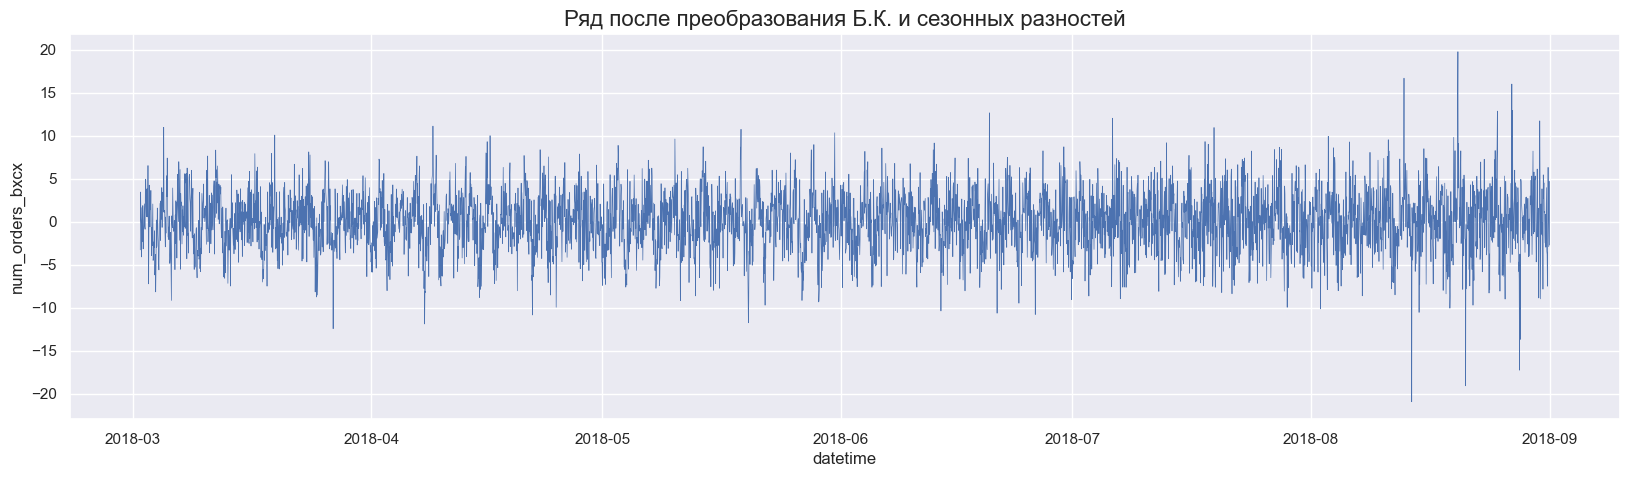

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=data_bxcx_res1D, lw=.5)
ax.set_title('Ряд после преобразования Б.К. и сезонных разностей', fontsize=16)
plt.show()

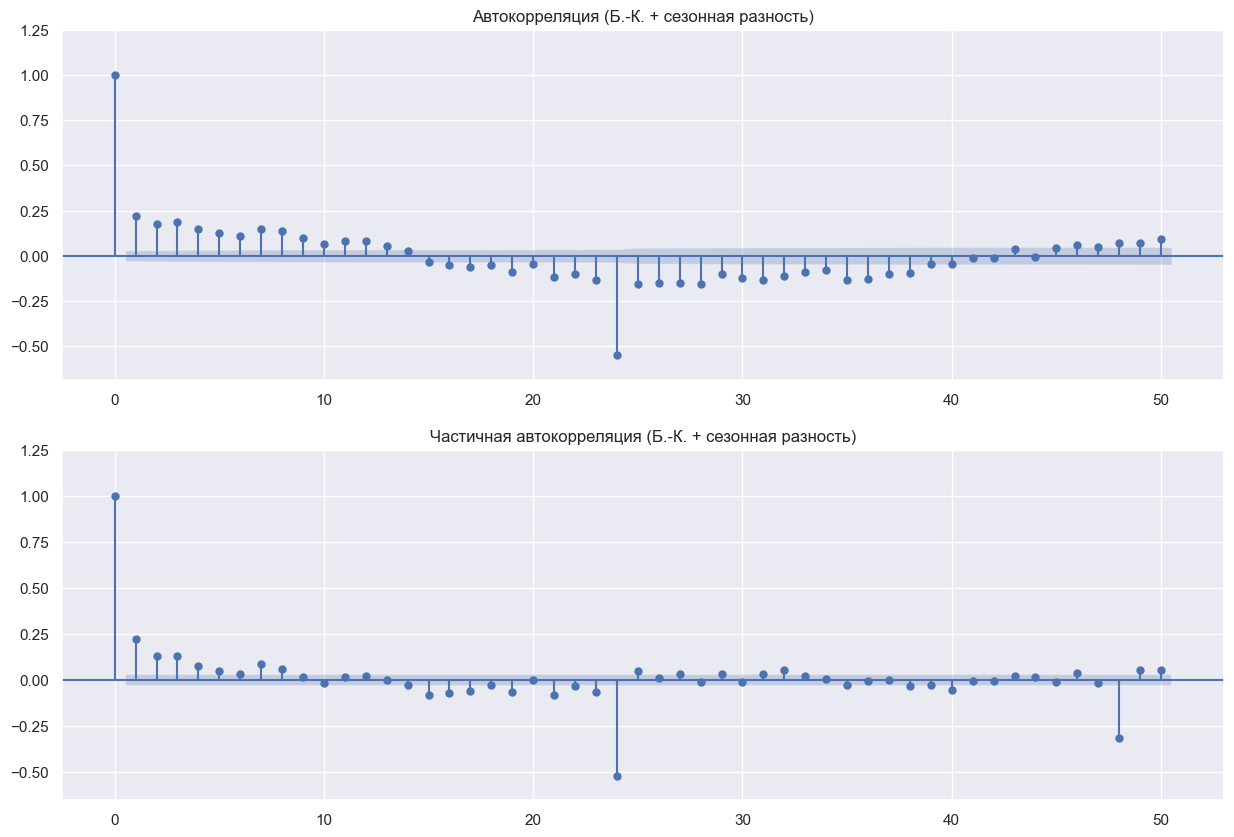

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(data_bxcx_res1D, lags=50, auto_ylims=True, ax=ax[0], title='Автокорреляция (Б.-К. + сезонная разность)')
plot_pacf(data_bxcx_res1D, lags=50, method='ywm', auto_ylims=True, ax=ax[1], title='Частичная автокорреляция (Б.-К. + сезонная разность)')
plt.show()

Таким образом ряд сезонных разностей является стационарным.

## Модель SARIMA

Построим ряд первых разностей полученного ряда (уже сделано преобразование Б-К. + сезонные разности)

In [19]:
data_bxcx_res1D_res1d = data_bxcx_res1D - data_bxcx_res1D.shift(1)
data_bxcx_res1D_res1d.dropna(inplace=True)

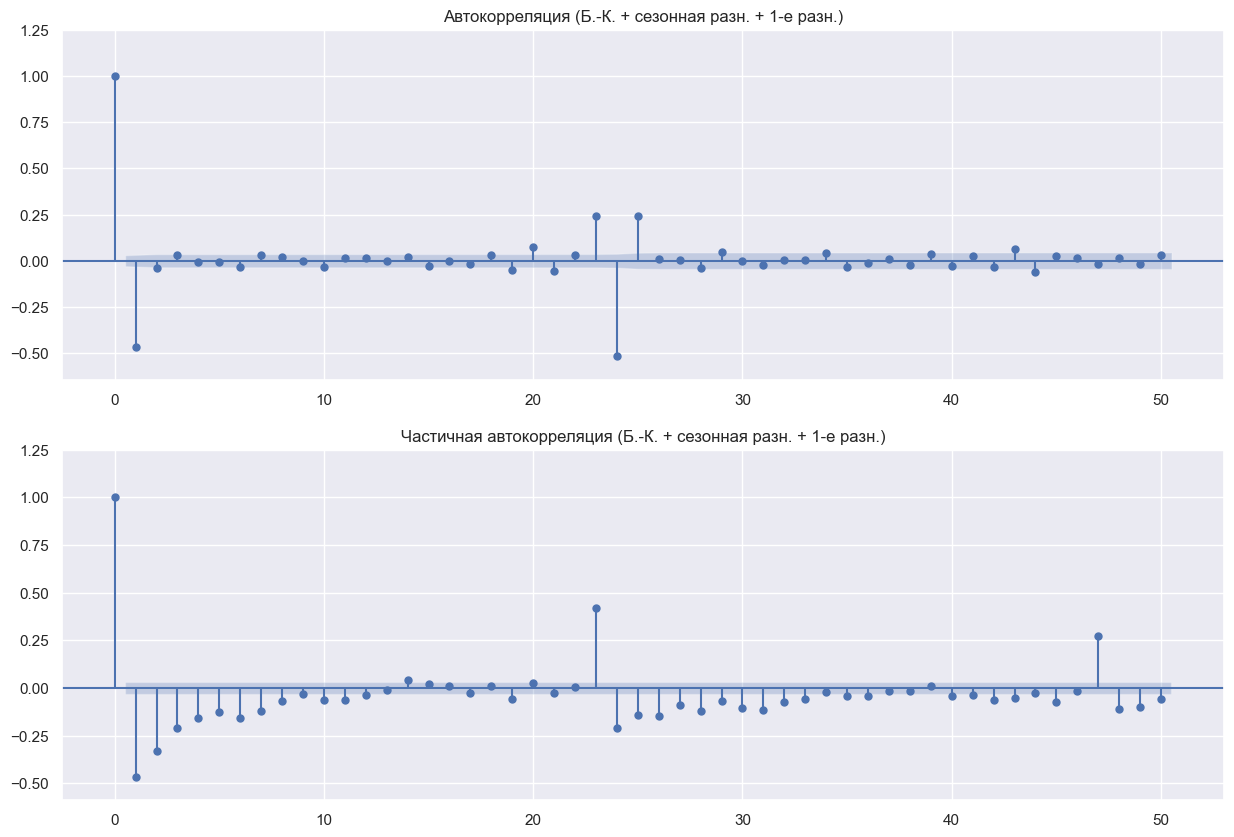

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(data_bxcx_res1D_res1d,
         lags=50,
         auto_ylims=True,
         ax=ax[0],
         title='Автокорреляция (Б.-К. + сезонная разн. + 1-е разн.)')
plot_pacf(data_bxcx_res1D_res1d,
          lags=50,
          method='ywm',
          auto_ylims=True,
          ax=ax[1],
          title='Частичная автокорреляция (Б.-К. + сезонная разн. + 1-е разн.)')
plt.show()

Теперь ACF и PACF используем, чтоб определить диапазоны значений (p, q) и (P, Q) для модели SARIMA. При этом значения **d** и **D** нам уже понятны, так как были построены сезонные и первые разности: `D = 1`, `d = 1` 

**p** -  указывает, сколько исторических значений используется для возврата прогнозируемого значения. Определяем по PACF, смотрим на номер лага, после которго остальные лаги можно считать незначимыми. В нашем случае `p = 0..3`

**q** - предназначена для моделирования ошибки временного ряда и предположения, что текущая ошибка зависит от ошибки с запаздыванием. Определяем по ACF. В нашем случае `q = 0..1`, так как после 1-го лага значимость остальных лагов резко падает.

**P** и **Q** определяются аналогично, но в расчет берутся сезонные лаги. В нашем случае `P = 0..3`, `Q = 0..1`

Разбиваем на тренировочные и тестовые данные

In [21]:
train_bxcx, test_bxcx = train_test_split(data_bxcx['num_orders_bxcx'], shuffle=False, test_size=0.1)
print(len(train_bxcx), '\t', train_bxcx.index.min(), ' - ', train_bxcx.index.max())
print(len(test_bxcx), '\t', test_bxcx.index.min(), ' - ', test_bxcx.index.max())

3974 	 2018-03-01 00:00:00  -  2018-08-13 13:00:00
442 	 2018-08-13 14:00:00  -  2018-08-31 23:00:00


Подбираем гиперпараметры модели

<div class="alert alert-info"> <b>Комментарий</b>

К сожалению, ядро умирает начиная с глубины данных примерно 24х17 записей от последнего индекса в тренировочных данных. Скорее всего проблема в вычислительных ресурсах. Поэтому поиск гиперпараметров - только на последних 14 днях.
</div>

In [22]:
SARIMA_model = pm.auto_arima(train_bxcx[-24*14:],
                             start_p=2, max_p=3,
                             start_P=2, max_P=3,   
                             d=1,
                             D=1,
                             start_q=1, max_q=1,   
                             start_Q=0, max_Q=1,
                             max_order=None, 
                             seasonal=True,
                             m=24,
                             trace=True,
                             error_action='warn',
                             suppress_warnings=True,
                             stepwise=True,
                             random_state=RND_ST)
display(SARIMA_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(2,1,0)[24]             : AIC=1562.832, Time=9.30 sec
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=1847.313, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=1706.276, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=1.93 sec
 ARIMA(2,1,1)(1,1,0)[24]             : AIC=1598.815, Time=1.36 sec
 ARIMA(2,1,1)(3,1,0)[24]             : AIC=1545.540, Time=14.23 sec
 ARIMA(2,1,1)(3,1,1)[24]             : AIC=1529.955, Time=27.68 sec
 ARIMA(2,1,1)(2,1,1)[24]             : AIC=inf, Time=12.18 sec
 ARIMA(1,1,1)(3,1,1)[24]             : AIC=1527.963, Time=20.36 sec
 ARIMA(1,1,1)(2,1,1)[24]             : AIC=inf, Time=8.84 sec
 ARIMA(1,1,1)(3,1,0)[24]             : AIC=1543.669, Time=11.68 sec
 ARIMA(1,1,1)(2,1,0)[24]             : AIC=1560.851, Time=5.98 sec
 ARIMA(0,1,1)(3,1,1)[24]             : AIC=1531.416, Time=16.02 sec
 ARIMA(1,1,0)(3,1,1)[24]             : AIC=inf, Time=13.68 sec
 ARIMA(0,1,0)(3,1,1)[24]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  336
Model:             SARIMAX(1, 1, 1)x(3, 1, 1, 24)   Log Likelihood                -756.982
Date:                            Thu, 29 Sep 2022   AIC                           1527.963
Time:                                    23:07:41   BIC                           1554.142
Sample:                                         0   HQIC                          1538.427
                                            - 336                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1585      0.057      2.768      0.006       0.046       0.271
ma.L1         -0.9697      0.023    -42.449      0.000      -1.014      -0.925
ar.S.L24      -0.2584      0.131     -1.968      0.049      -0.516      -0.001
ar.S.L48      -0.1415      0.125     -1.131      0.258      -0.387       0.104
ar.S.L72      -0.0594      0.102     -0.584      0.560      -0.259       0.140
ma.S.L24      -0.7636      0.131     -5.844      0.000      -1.020      -0.507
sigma2         6.7014      0.415     16.134      0.000       5.887       7.516
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                78.62
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               1.44   Skew:                             0.58
Prob(H) (two-sided):                  0.06   Kurtosis:                         5.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Обучаем на всех тренировочных данных, строим прогноз

In [23]:
sarima_preds_bxcx = SARIMA_model.fit_predict(train_bxcx, n_periods=len(test_bxcx))
sarima_preds = pd.Series(
    np.rint(invbxcx(sarima_preds_bxcx, lmbda)).astype('int'), index=test_bxcx.index
)

In [24]:
test = data_H['num_orders'][test_bxcx.index[0] : test_bxcx.index[-1]]
sarima_rmse = mean_squared_error(test, sarima_preds, squared=False)

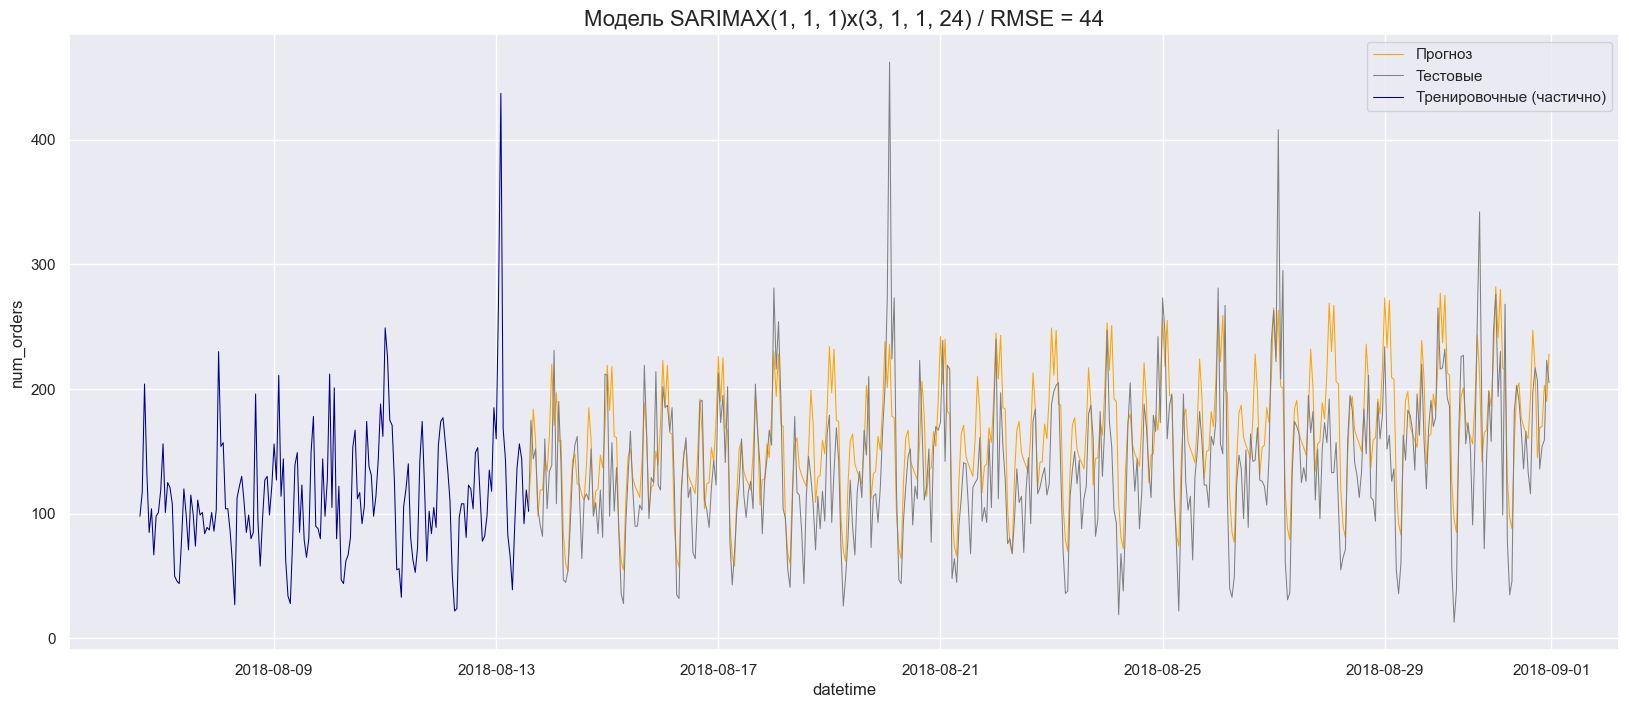

In [59]:
model_label = SARIMA_model.summary().tables[0][1][1].format(0)

fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title(
    'Модель ' +model_label +' / RMSE = ' +str(round(sarima_rmse)), fontsize=16
)
sns.lineplot(data=sarima_preds, label='Прогноз', lw=.75, color='orange', ax=ax)
sns.lineplot(data=test, label='Тестовые', lw=.75, color='grey', ax=ax)
sns.lineplot(
    data=data_H['num_orders'][test.index[0] +pd.offsets.Day(-7) : test.index[0]],
    label='Тренировочные (частично)',
    lw=.75,
    color='darkblue',
    ax=ax
)
ax.legend(loc='best')
plt.show()

**ВЫВОД:** Значение `RMSE` равно 44, что меньше требуемого порога 48.

## Подготовка признаков

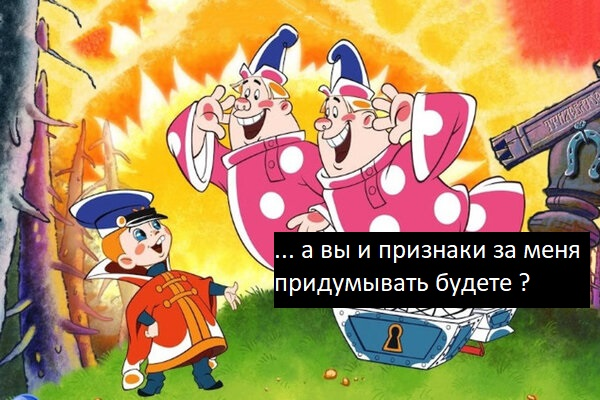

Воспользуемся библиотекой [tsfresh](https://tsfresh.readthedocs.io/en/latest/#) для генерации признаков

In [26]:
'''убираем параметры 'friedrich_coefficients' и 'max_langevin_fixed_point' из <default_fc_parameters>
   иначе функция extract_features в версии Python 3.9 выдает ошибку'''

tsf_settings = ComprehensiveFCParameters()
del tsf_settings['friedrich_coefficients']
del tsf_settings['max_langevin_fixed_point']

Функция [make_forecasting_frame](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.utilities.html?highlight=make_forecasting_frame#tsfresh.utilities.dataframe_functions.make_forecasting_frame) позволяет разметить TimeSeries для последующей генерации признаков. Выбираем параметр `max_timeshift=72` так как ранее в SARIMA мы нашли, что `P = 3` а наша сезонность это 24.

In [27]:
fch_roll, trgt = make_forecasting_frame(data_H['num_orders'], kind='num_ordrs', rolling_direction=1, max_timeshift=72)
trgt.index = trgt.index.map(lambda x: x[1])

Rolling: 100%|██████████| 20/20 [00:16<00:00,  1.22it/s]


In [28]:
print('rolling data', fch_roll.shape, type(fch_roll))
print('from', fch_roll['time'].min(), 'to', fch_roll['time'].max())
print()
print('target', trgt.shape, type(trgt))
print('from', trgt.index.min(), 'to', trgt.index.max())

rolling data (315324, 4) <class 'pandas.core.frame.DataFrame'>
from 2018-03-01 00:00:00 to 2018-08-31 22:00:00

target (4415,) <class 'pandas.core.series.Series'>
from 2018-03-01 01:00:00 to 2018-08-31 23:00:00


Теперь переходим непосредственно к генерации признаков. Применяем [extract_features](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html?highlight=extract_features#tsfresh.feature_extraction.extraction.extract_features), используя созданный на предыдущем шаге контейнер `fch_roll`

In [29]:
fch_tsf = extract_features(timeseries_container=fch_roll,
                           default_fc_parameters=tsf_settings,
                           column_id='id',
                           column_sort='time',
                           column_value='value',
                           impute_function=impute)

fch_tsf = fch_tsf.droplevel(level=0)

Feature Extraction: 100%|██████████| 20/20 [02:49<00:00,  8.49s/it]


In [30]:
print('features', fch_tsf.shape, type(fch_tsf))
print('from', fch_tsf.index.min(), 'to', fch_tsf.index.max())

features (4415, 784) <class 'pandas.core.frame.DataFrame'>
from 2018-03-01 01:00:00 to 2018-08-31 23:00:00


Из всех созданных признаков нам нужны только те, которые имеют высокую корреляцию с целевой переменной. Для выбора таких признаков воспользуемся [calculate_relevance_table](https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_selection.html?highlight=calculate_relevance_table#tsfresh.feature_selection.relevance.calculate_relevance_table) с пороговым значением `p-Value=.05` (параметр `fdr_level`)

In [31]:
fch_relevance_table = calculate_relevance_table(X=fch_tsf,
                                                y=trgt,
                                                ml_task='regression',
                                                fdr_level=5e-2)

In [32]:
fch_tsf_rel = fch_tsf[fch_relevance_table[fch_relevance_table['relevant']==True]['feature']]

Получили 330 признаков. Неплохо! :)

In [33]:
fch_tsf_rel.shape

(4415, 330)

Проверим размерности ...

In [60]:
fch_tsf_train, fch_tsf_test = train_test_split(
    fch_tsf_rel, shuffle=False, test_size=0.1
)
trgt_train, trgt_test = train_test_split(
    trgt, shuffle=False, test_size=0.1
)
print(
    'features train',
    '\t',
    len(fch_tsf_train),
    '\t',
    fch_tsf_train.index.min(),
    ' - ',
    fch_tsf_train.index.max()
)
print(
    'target train',
    '\t',
    len(trgt_train),
    '\t',
    trgt_train.index.min(),
    ' - ',
    trgt_train.index.max()
)
print()

print(
    'features test',
    '\t',
    len(fch_tsf_test),
    '\t',
    fch_tsf_test.index.min(),
    ' - ',
    fch_tsf_test.index.max()
)
print(
    'target test',
    '\t',
    len(trgt_test),
    '\t',
    trgt_test.index.min(),
    ' - ',
    trgt_test.index.max()
)

features train 	 3973 	 2018-03-01 01:00:00  -  2018-08-13 13:00:00
target train 	 3973 	 2018-03-01 01:00:00  -  2018-08-13 13:00:00

features test 	 442 	 2018-08-13 14:00:00  -  2018-08-31 23:00:00
target test 	 442 	 2018-08-13 14:00:00  -  2018-08-31 23:00:00


Отлично! Все соответствует - теперь можно переходить к моделям ...

## Модель LinearRegression

In [35]:
LR_model = LinearRegression()
LR_model.fit(fch_tsf_train, trgt_train)

LinearRegression()

In [36]:
LR_preds = LR_model.predict(fch_tsf_test)
LR_preds = pd.Series(np.rint(LR_preds).astype('int'), index=test.index)

In [37]:
test = data_H['num_orders'][trgt_test.index[0] : trgt_test.index[-1]]
LR_rmse = mean_squared_error(test, LR_preds, squared=False)

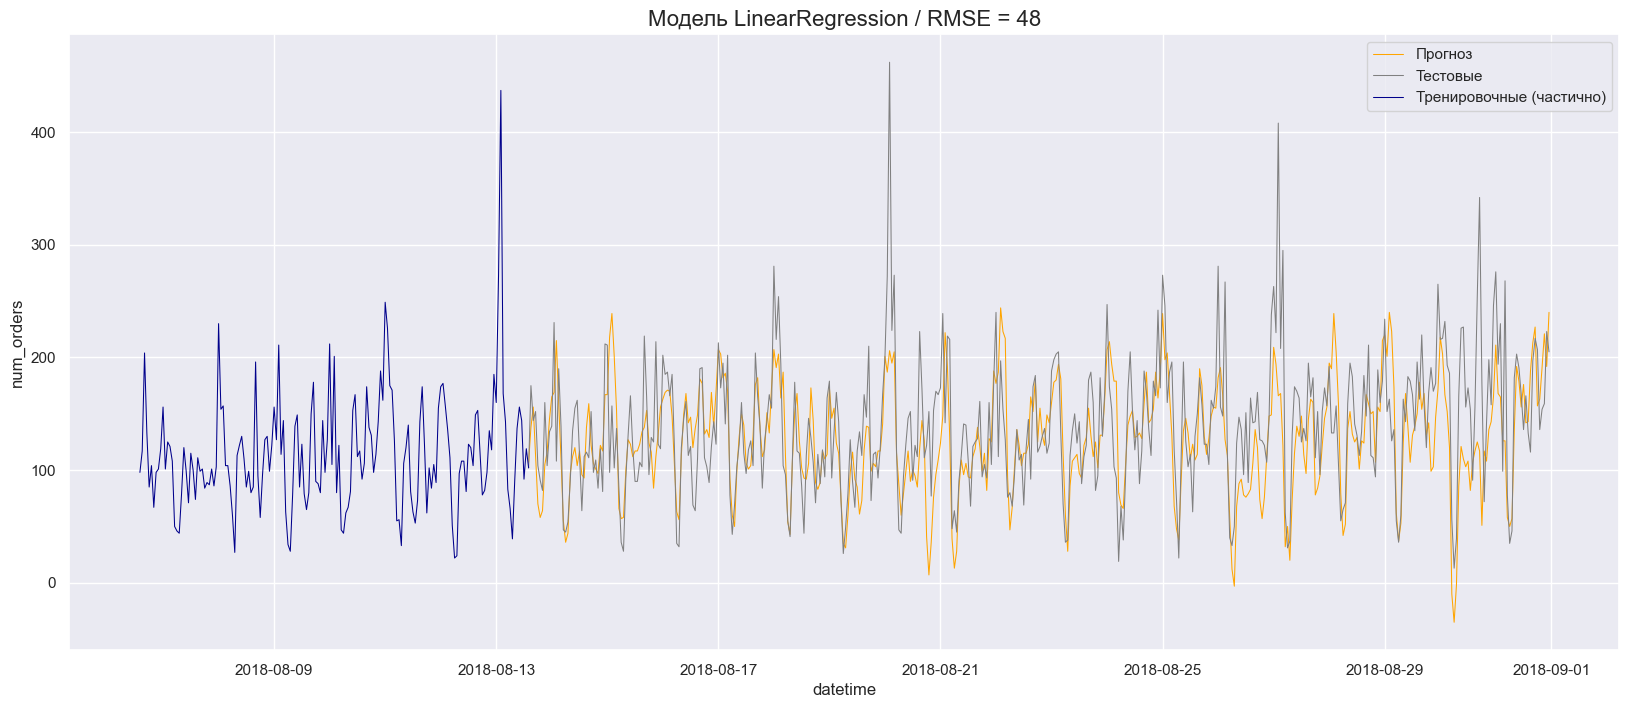

In [58]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title(
    'Модель LinearRegression' +' / RMSE = ' +str(round(LR_rmse)),
    fontsize=16
)
sns.lineplot(data=LR_preds, label='Прогноз', lw=.75, color='orange', ax=ax)
sns.lineplot(data=test, label='Тестовые', lw=.75, color='grey', ax=ax)
sns.lineplot(
    data=data_H['num_orders'][test.index[0] +pd.offsets.Day(-7) : test.index[0]],
    label='Тренировочные (частично)',
    lw=.75,
    color='darkblue',
    ax=ax)
ax.legend(loc='best')
plt.show()

Можно сказать - это "baseline" :) Модель чётко уложилась в трешолд.

## Модель CatBoostRegressor

Для подбора гиперпараметров воспользуемся [optuna](https://optuna.org/)

In [48]:
def objective_CBR(trial, features=fch_tsf_train, target=trgt_train):
    
    X_train, X_val, y_train, y_val = train_test_split(
        features, target, shuffle=False, test_size=.1, random_state=RND_ST
    )
    
    params = {'max_depth': trial.suggest_int('max_depth', 3, 5),                        
              'learning_rate': trial.suggest_float('learning_rate', .05, .6),
              'n_estimators': trial.suggest_int('n_estimators', 700, 1000),            
             }
    
    model = CatBoostRegressor(**params,
                              eval_metric='RMSE',
                              random_state=RND_ST)
    
    model.fit(X_train,
              y_train,
              eval_set = [(X_val, y_val)],
              early_stopping_rounds=100,
              verbose=False)
    
    return model.get_best_score()['validation']['RMSE']

In [49]:
study_cbr = optuna.create_study(direction = 'minimize', study_name='CatBoostRegressor')
study_cbr.optimize(objective_CBR, n_trials = 50)

[I 2022-09-29 23:18:51,457] A new study created in memory with name: CatBoostRegressor
[I 2022-09-29 23:18:53,345] Trial 0 finished with value: 32.450978197826615 and parameters: {'max_depth': 4, 'learning_rate': 0.37287546431799884, 'n_estimators': 846}. Best is trial 0 with value: 32.450978197826615.
[I 2022-09-29 23:18:54,711] Trial 1 finished with value: 32.049360331130025 and parameters: {'max_depth': 3, 'learning_rate': 0.350294401507502, 'n_estimators': 729}. Best is trial 1 with value: 32.049360331130025.
[I 2022-09-29 23:18:57,814] Trial 2 finished with value: 32.994015792161804 and parameters: {'max_depth': 5, 'learning_rate': 0.21064818346562947, 'n_estimators': 899}. Best is trial 1 with value: 32.049360331130025.
[I 2022-09-29 23:18:59,280] Trial 3 finished with value: 32.50038068742157 and parameters: {'max_depth': 3, 'learning_rate': 0.3822789055038253, 'n_estimators': 793}. Best is trial 1 with value: 32.049360331130025.
[I 2022-09-29 23:19:02,280] Trial 4 finished with

Оптимальные гиперпараметры

In [50]:
study_cbr.best_params

{'max_depth': 4, 'learning_rate': 0.11721988915858508, 'n_estimators': 864}

Формиируем словарь параметров для инициализации модели

In [51]:
cbr_best_params = study_cbr.best_params
cbr_best_params.update({'loss_function':'RMSE',
                        'random_state': RND_ST,
                        'verbose': False})

Создаем экземпляр класса, обучаем, делаем прогноз

In [52]:
CBR_model = CatBoostRegressor(**cbr_best_params)
CBR_model.fit(Pool(data=fch_tsf_train, label=trgt_train))
CBR_preds = pd.Series(
    np.rint(CBR_model.predict(fch_tsf_test)).astype('int'),
    index=test.index
)

In [53]:
CBR_rmse = mean_squared_error(test, CBR_preds, squared=False)

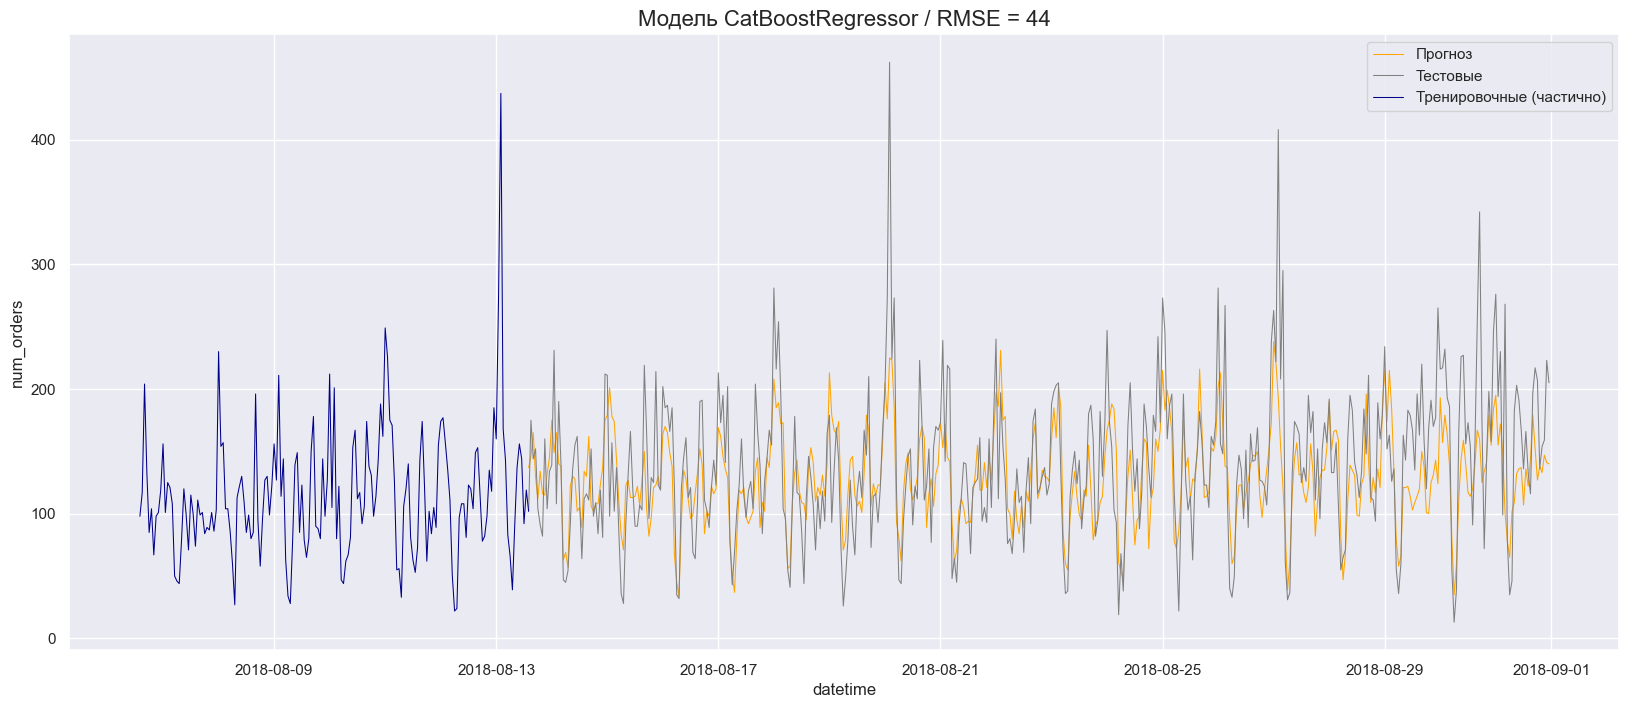

In [57]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.set_title(
    'Модель CatBoostRegressor' +' / RMSE = ' +str(round(CBR_rmse)),
    fontsize=16)
sns.lineplot(data=CBR_preds, label='Прогноз', lw=.75, color='orange', ax=ax)
sns.lineplot(data=test, label='Тестовые', lw=.75, color='grey', ax=ax)
sns.lineplot(
    data=data_H['num_orders'][test.index[0] +pd.offsets.Day(-7) : test.index[0]],
    label='Тренировочные (частично)',
    lw=.75,
    color='darkblue',
    ax=ax)
ax.legend(loc='best')
plt.show()

## Общий вывод

In [78]:
(
    pd.DataFrame(data=[sarima_rmse, LR_rmse, CBR_rmse],
             columns=['RMSE'],
             index=[model_label, 'LinearRegression', 'CatBoostRegressor'])
    .sort_values('RMSE')
)

,RMSE
CatBoostRegressor,43.635030
"SARIMAX(1, 1, 1)x(3, 1, 1, 24)",44.164286
LinearRegression,47.672881


Очень близко `SARIMA` и `CatBoost` ... но в примере с `SARIMA` мы подбирали гиперпараметры только на 2-х последних неделях ... возможно есть более оптимальная конфигурация. Однако, по метрике "трудозатраты - результат" `CatBoost` на мой взгляд сильно выигрывает!